In [47]:
import pandas as pd
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle

In [48]:
len(glob("res_tmp/*/*.csv"))

2539

In [49]:
dfs = []
trees = []
for filename in tqdm(glob("res_tmp/*/*.csv")):
    dfs.append(pd.read_csv(filename))
    dfs[-1]['dataset'] = filename.split('/')[1]
    with open(filename.replace('.csv', '.pickle'), 'rb') as f:
        trees.append(pickle.load(f))

  0%|          | 0/2539 [00:00<?, ?it/s]

In [74]:
lista_dataset = [
    'iris',
    'vertebral',
    'home',
    'auction',
    'seeds',
    'ecoli',
    'bankMarketing',
    'magic',
    'diabetes',
    'titanic',
    'glass', 
    'covertype'
]

marker_HDT = 'o' #'o'
marker_ONLY = 's' #r'$1$'
marker_no = '^' #'_'
marker_no_family = '*' # 'x'

viz_dict = {
    'HDT': (r'$\mathrm{HDT}$', marker_HDT, 'black'),
    
    'ONLY_Decision': (r'$\mathrm{UDT}$', marker_ONLY, '#a6cee3'),
    'ONLY_ObliqueDecision': (r'$\mathrm{ODT}$', marker_ONLY, '#1f78b4'),
    'ONLY_Pivot': (r'$\mathrm{PT}$', marker_ONLY, '#b2df8a'),
    'ONLY_MultiplePivot': (r'$\mathrm{PPT}$', marker_ONLY, '#33a02c'),
    'ONLY_PartialPivot': (r'$\mathrm{SPT}$', marker_ONLY, '#fb9a99'),
    'ONLY_PartialProximity': (r'$\mathrm{SPPT}$', marker_ONLY, '#e31a1c'),

    'HDT_no_DecisionTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{UDT}}$', marker_no, '#a6cee3'),
    'HDT_no_ObliqueDecisionTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{ODT}}$', marker_no, '#1f78b4'),
    'HDT_no_PivotTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{PT}}$', marker_no, '#b2df8a'),
    'HDT_no_MultiplePivotTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{PDT}}$', marker_no, '#33a02c'),
    'HDT_no_PartialPivotTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{SPT}}$', marker_no, '#fb9a99'),
    'HDT_no_PartialProximityTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{SPPT}}$', marker_no, '#e31a1c'),

    'HDT_no_classic': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{UDT}, \mathrm{ODT}}$', marker_no_family, '#1f78b4'),
    'HDT_no_pivot': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{PT}, \mathrm{PPT}}$', marker_no_family, '#33a02c'),
    'HDT_no_partial': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{SPT}, \mathrm{SPPT}}$', marker_no_family, '#e31a1c'),
}

## Count stump

In [75]:
def list_stump(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    return [node.stump.__class__.__name__] + list_stump(node.node_l) + list_stump(node.node_r)

In [76]:
trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump(tree.root))

In [77]:
all_available_stumps = set()

for stump_list in trees_stumps:
    all_available_stumps |= set(stump_list)

In [78]:
all_available_stumps

{'DecisionTreeStumpClassifier',
 'MultiplePivotTreeStumpClassifier',
 'ObliqueDecisionTreeStumpClassifier',
 'PartialPivotTreeStumpClassifier',
 'PartialProximityTreeStumpClassifier',
 'PivotTreeStumpClassifier'}

In [79]:
count = []
for used_stumps in trees_stumps:
    c = {s: used_stumps.count(s) for s in all_available_stumps}
    count.append(c)

df_count = pd.DataFrame(count)
df_count.rename(columns={x: x.replace('TreeStumpClassifier', '') for x in df_count.columns}, inplace=True)

In [80]:
df_count

,Pivot,MultiplePivot,PartialPivot,Decision,PartialProximity,ObliqueDecision
0,4,0,1,0,1,0
1,0,0,6,0,0,0
2,4,0,0,1,1,0
3,3,0,1,0,1,1
4,4,0,0,0,2,0
...,...,...,...,...,...,...
2534,0,0,3,1,0,1
2535,0,0,0,6,0,0
2536,0,0,0,0,6,0
2537,0,0,1,2,1,1


## Count stump weight

In [81]:
def list_stump_w(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    return [(node.stump.__class__.__name__, 1/depth)] + list_stump_w(node.node_l, depth+1) + list_stump_w(node.node_r, depth+1)

trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump_w(tree.root))

count_w = []
for used_stumps in trees_stumps:
    c = dict()
    for stump_to_check in all_available_stumps:
        c[stump_to_check] = 0
        for stump_name, w in used_stumps:
            if stump_to_check == stump_name:
                c[stump_name] += w
    
    #c = {s: used_stumps.sum(s) for s in all_available_stumps}
    count_w.append(c)

df_count_w = pd.DataFrame(count_w)
df_count_w.rename(columns={x: x.replace('TreeStumpClassifier', '')+'_w' for x in df_count_w.columns}, inplace=True)

df_count_w

,Pivot_w,MultiplePivot_w,PartialPivot_w,Decision_w,PartialProximity_w,ObliqueDecision_w
0,1.500000,0.0,0.500000,0.000000,1.0,0.000000
1,0.000000,0.0,3.000000,0.000000,0.0,0.000000
2,1.500000,0.0,0.000000,1.000000,0.5,0.000000
3,1.166667,0.0,1.000000,0.000000,0.5,0.333333
4,1.500000,0.0,0.000000,0.000000,1.5,0.000000
...,...,...,...,...,...,...
2534,0.000000,0.0,1.166667,1.000000,0.0,0.500000
2535,0.000000,0.0,0.000000,3.000000,0.0,0.000000
2536,0.000000,0.0,0.000000,0.000000,3.0,0.000000
2537,0.000000,0.0,0.500000,0.666667,1.0,0.500000


In [82]:
from RuleTree.utils.data_utils import get_info_gain

def list_stump_w_info(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    return [(node.stump.__class__.__name__, get_info_gain(node.stump))] + list_stump_w(node.node_l, depth+1) + list_stump_w(node.node_r, depth+1)

trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump_w_info(tree.root))

count_w_info = []
for used_stumps in trees_stumps:
    c = dict()
    for stump_to_check in all_available_stumps:
        c[stump_to_check] = 0
        for stump_name, w in used_stumps:
            if stump_to_check == stump_name:
                c[stump_name] += w
    
    #c = {s: used_stumps.sum(s) for s in all_available_stumps}
    count_w_info.append(c)

df_count_w_info = pd.DataFrame(count_w_info)
df_count_w_info.rename(columns={x: x.replace('TreeStumpClassifier', '')+'_w_info' for x in df_count_w_info.columns}, inplace=True)

df_count_w_info

,Pivot_w_info,MultiplePivot_w_info,PartialPivot_w_info,Decision_w_info,PartialProximity_w_info,ObliqueDecision_w_info
0,1.500000,0.0,0.500000,0.000000,0.344970,0.000000
1,0.000000,0.0,2.339228,0.000000,0.000000,0.000000
2,1.500000,0.0,0.000000,0.339228,0.500000,0.000000
3,1.166667,0.0,0.350184,0.000000,0.500000,0.333333
4,1.500000,0.0,0.000000,0.000000,0.839228,0.000000
...,...,...,...,...,...,...
2534,0.000000,0.0,1.166667,0.307106,0.000000,0.500000
2535,0.000000,0.0,0.000000,2.307106,0.000000,0.000000
2536,0.000000,0.0,0.000000,0.000000,2.307106,0.000000
2537,0.000000,0.0,0.500000,0.666667,0.307106,0.500000


In [83]:
from RuleTree.utils.data_utils import get_info_gain

def list_stump_w_imp(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    samples = node.samples
    samples_l = node.node_l.samples
    samples_r = node.node_r.samples
    impurity, impurity_l, impurity_r = tree.root.stump.tree_.impurity
    impurity_decrease = impurity - (samples_l*impurity_l + samples_r*impurity_r)/samples
    
    return [(node.stump.__class__.__name__, impurity_decrease * samples)] + list_stump_w(node.node_l, depth+1) + list_stump_w(node.node_r, depth+1)

trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump_w_imp(tree.root))

count_w_imp = []
for used_stumps in trees_stumps:
    c = dict()
    for stump_to_check in all_available_stumps:
        c[stump_to_check] = 0
        for stump_name, w in used_stumps:
            if stump_to_check == stump_name:
                c[stump_name] += w
    
    #c = {s: used_stumps.sum(s) for s in all_available_stumps}
    count_w_imp.append(c)

df_count_w_imp = pd.DataFrame(count_w_imp)
df_count_w_imp.rename(columns={x: x.replace('TreeStumpClassifier', '')+'_w_imp' for x in df_count_w_imp.columns}, inplace=True)

df_count_w_imp

,Pivot_w_imp,MultiplePivot_w_imp,PartialPivot_w_imp,Decision_w_imp,PartialProximity_w_imp,ObliqueDecision_w_imp
0,1.500000,0.0,0.500000,0.000000,85.552660,0.000000
1,0.000000,0.0,86.128460,0.000000,0.000000,0.000000
2,1.500000,0.0,0.000000,84.128460,0.500000,0.000000
3,1.166667,0.0,86.845738,0.000000,0.500000,0.333333
4,1.500000,0.0,0.000000,0.000000,84.628460,0.000000
...,...,...,...,...,...,...
2534,0.000000,0.0,1.166667,51.593886,0.000000,0.500000
2535,0.000000,0.0,0.000000,53.593886,0.000000,0.000000
2536,0.000000,0.0,0.000000,0.000000,53.593886,0.000000
2537,0.000000,0.0,0.500000,0.666667,51.593886,0.500000


In [84]:
tree.root.stump.tree_.impurity

array([0.66666667, 0.        , 0.52506616])

## Ablation study

In [85]:
df = pd.concat(dfs, ignore_index=True)

df[df_count.columns] = df_count.values
df[df_count_w.columns] = df_count_w.values
df[df_count_w_info.columns] = df_count_w_info.values
df[df_count_w_imp.columns] = df_count_w_imp.values

df

,max_depth,prune_useless_leaves,stump_selection,random_state,splitter,base_stumps,distance_measure,method,DecisionTreeStumpClassifier,ObliqueDecisionTreeStumpClassifier,...,PartialPivot_w_info,Decision_w_info,PartialProximity_w_info,ObliqueDecision_w_info,Pivot_w_imp,MultiplePivot_w_imp,PartialPivot_w_imp,Decision_w_imp,PartialProximity_w_imp,ObliqueDecision_w_imp
0,3,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_MultiplePivotTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.500000,0.000000,0.344970,0.000000,1.500000,0.0,0.500000,0.000000,85.552660,0.000000
1,3,True,best,42,best,['PartialPivotTreeStumpClassifier'],euclidean,ONLY_PartialPivot,NaN,NaN,...,2.339228,0.000000,0.000000,0.000000,0.000000,0.0,86.128460,0.000000,0.000000,0.000000
2,3,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_PartialPivotTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.339228,0.500000,0.000000,1.500000,0.0,0.000000,84.128460,0.500000,0.000000
3,3,True,best,42,best,"['ObliqueDecisionTreeStumpClassifier', 'PivotT...",euclidean,HDT_no_DecisionTreeStumpClassifier,NaN,"{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.350184,0.000000,0.500000,0.333333,1.166667,0.0,86.845738,0.000000,0.500000,0.333333
4,3,True,best,42,best,"['ObliqueDecisionTreeStumpClassifier', 'PivotT...",euclidean,HDT_no_DecisionTreeStumpClassifier,NaN,"{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.000000,0.839228,0.000000,1.500000,0.0,0.000000,0.000000,84.628460,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,3,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_pivot,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,1.166667,0.307106,0.000000,0.500000,0.000000,0.0,1.166667,51.593886,0.000000,0.500000
2535,3,True,best,42,best,['DecisionTreeStumpClassifier'],euclidean,ONLY_Decision,"{'max_depth': 1, 'random_state': 42}",NaN,...,0.000000,2.307106,0.000000,0.000000,0.000000,0.0,0.000000,53.593886,0.000000,0.000000
2536,3,True,best,42,best,['PartialProximityTreeStumpClassifier'],euclidean,ONLY_PartialProximity,NaN,NaN,...,0.000000,0.000000,2.307106,0.000000,0.000000,0.0,0.000000,0.000000,53.593886,0.000000
2537,3,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_pivot,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.500000,0.666667,0.307106,0.500000,0.000000,0.0,0.500000,0.666667,51.593886,0.500000


In [86]:
df_original = df.copy(deep=True)

df = df[df.dataset.isin(lista_dataset)].copy(deep=True)

#df = df_original.copy(deep=True)

In [87]:
for max_depth in sorted(df.max_depth.unique()):
    print(max_depth, 
          round(df[df.max_depth==max_depth].resulting_max_depth_test.min(), 3),
          round(df[df.max_depth==max_depth].resulting_max_depth_test.mean(), 3),
          round(df[df.max_depth==max_depth].resulting_max_depth_test.max(), 3), sep="\t"
         )

3	3	3.992	4


In [88]:
#df_best = df[df.max_depth==5].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)
df_best = df.sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)

df_best_pivot = df_best.pivot(index=['dataset'], columns=['method'], values='f1_macro_test')

df_best_pivot.T.style.background_gradient(cmap='coolwarm')

dataset,auction,bankMarketing,covertype,diabetes,ecoli,glass,home,iris,magic,seeds,titanic,vertebral
method,,,,,,,,,,,,
HDT,0.902319,0.729831,0.742460,0.645977,0.540277,0.403704,0.908756,0.932660,0.679468,0.876628,0.730569,0.678497
HDT_no_DecisionTreeStumpClassifier,0.843746,0.751367,0.738529,0.657778,0.496667,0.404915,0.887744,0.899749,0.662832,0.822401,0.738886,0.721516
HDT_no_MultiplePivotTreeStumpClassifier,0.855766,0.739837,0.742370,0.626743,0.512338,0.414440,0.897727,0.966583,0.496667,0.876628,0.737635,0.690145
HDT_no_ObliqueDecisionTreeStumpClassifier,0.902319,0.717357,0.729993,0.672745,0.510417,0.361940,0.918786,0.932660,0.522717,0.849926,0.711755,0.697806
HDT_no_PartialPivotTreeStumpClassifier,0.774458,0.731087,0.747233,0.629808,0.514927,0.351247,0.897727,0.932660,0.498095,0.849926,0.756564,0.819275
HDT_no_PartialProximityTreeStumpClassifier,0.848350,0.717713,0.753614,0.674231,0.486174,0.415242,0.877273,0.932660,0.496667,0.849926,0.766717,0.706532
HDT_no_PivotTreeStumpClassifier,0.872665,0.744483,0.734675,0.671797,0.664847,0.492649,0.898148,0.966583,0.673415,0.849926,0.775955,0.768801
HDT_no_classic,0.874951,0.724752,0.762122,0.655782,0.498095,0.399019,0.918786,0.932660,0.498095,0.876628,0.744081,0.678338
HDT_no_partial,0.570733,0.731761,0.722496,0.666454,0.498095,0.351247,0.866007,0.966583,0.498095,0.876628,0.805435,0.798030


In [89]:
[viz_dict[x][0] for x in df_best_pivot.columns]

['$\\mathrm{HDT}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{UDT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{PDT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{ODT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{SPT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{SPPT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{PT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{UDT}, \\mathrm{ODT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{SPT}, \\mathrm{SPPT}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{PT}, \\mathrm{PPT}}$',
 '$\\mathrm{UDT}$',
 '$\\mathrm{PPT}$',
 '$\\mathrm{ODT}$',
 '$\\mathrm{SPT}$',
 '$\\mathrm{SPPT}$',
 '$\\mathrm{PT}$']

dataset,auction,bankMarketing,covertype,diabetes,ecoli,glass,home,iris,magic,seeds,titanic,vertebral
method,,,,,,,,,,,,
HDT,0.902319,0.729831,0.742460,0.645977,0.540277,0.403704,0.908756,0.932660,0.679468,0.876628,0.730569,0.678497
HDT_no_DecisionTreeStumpClassifier,0.843746,0.751367,0.738529,0.657778,0.496667,0.404915,0.887744,0.899749,0.662832,0.822401,0.738886,0.721516
HDT_no_MultiplePivotTreeStumpClassifier,0.855766,0.739837,0.742370,0.626743,0.512338,0.414440,0.897727,0.966583,0.496667,0.876628,0.737635,0.690145
HDT_no_ObliqueDecisionTreeStumpClassifier,0.902319,0.717357,0.729993,0.672745,0.510417,0.361940,0.918786,0.932660,0.522717,0.849926,0.711755,0.697806
HDT_no_PartialPivotTreeStumpClassifier,0.774458,0.731087,0.747233,0.629808,0.514927,0.351247,0.897727,0.932660,0.498095,0.849926,0.756564,0.819275
HDT_no_PartialProximityTreeStumpClassifier,0.848350,0.717713,0.753614,0.674231,0.486174,0.415242,0.877273,0.932660,0.496667,0.849926,0.766717,0.706532
HDT_no_PivotTreeStumpClassifier,0.872665,0.744483,0.734675,0.671797,0.664847,0.492649,0.898148,0.966583,0.673415,0.849926,0.775955,0.768801
HDT_no_classic,0.874951,0.724752,0.762122,0.655782,0.498095,0.399019,0.918786,0.932660,0.498095,0.876628,0.744081,0.678338
HDT_no_partial,0.570733,0.731761,0.722496,0.666454,0.498095,0.351247,0.866007,0.966583,0.498095,0.876628,0.805435,0.798030


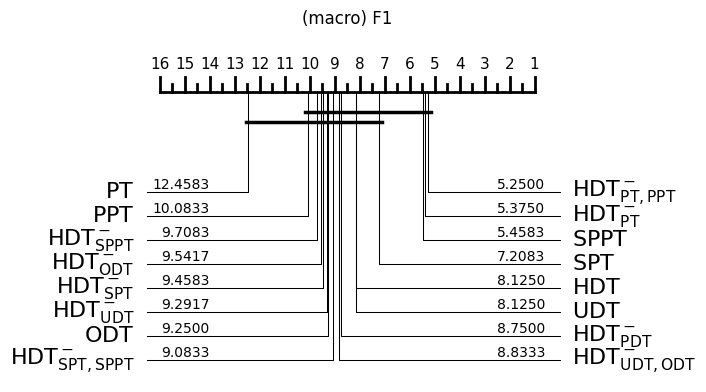

In [90]:
from aeon.visualisation import plot_critical_difference

df_best_pivot.dropna(inplace=True)

display(df_best_pivot.T.style.background_gradient(cmap='coolwarm'))

plot_critical_difference(df_best_pivot[df_best_pivot.columns[::-1]].values, 
                         labels=[viz_dict[x][0].replace('{\\, - \\,}', '-') for x in df_best_pivot.columns][::-1], 
                         lower_better=False, alpha=.1, 
                         test='nemenyi')
plt.title('(macro) F1')
plt.savefig("z_img_2Ablation_depth3_F1.png", dpi=300, bbox_inches='tight', )
plt.show()

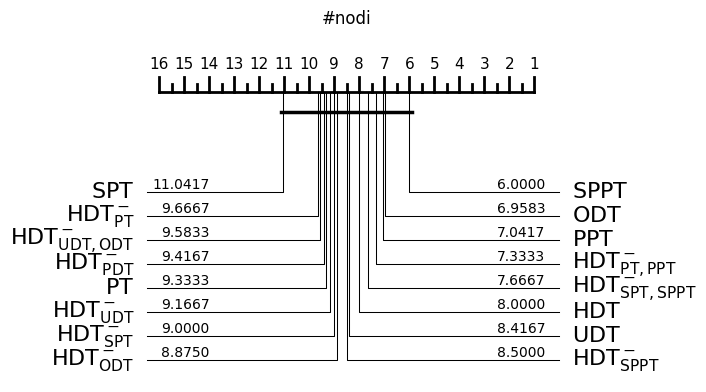

In [91]:
#df_best = df[df.max_depth==5].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)
df_best = df.sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)

df_best_pivot = df_best.pivot(index=['dataset'], columns=['method'], values='n_nodes_test')

df_best_pivot.T.style.background_gradient(cmap='coolwarm')


plot_critical_difference(df_best_pivot.values, 
                         labels=[viz_dict[x][0].replace('{\\, - \\,}', '-') for x in df_best_pivot.columns], 
                         lower_better=True, alpha=.1, test='nemenyi')
plt.title('#nodi')
plt.savefig("z_img_2Ablation_depth3_nodi.png", dpi=300, bbox_inches='tight', )
plt.show()

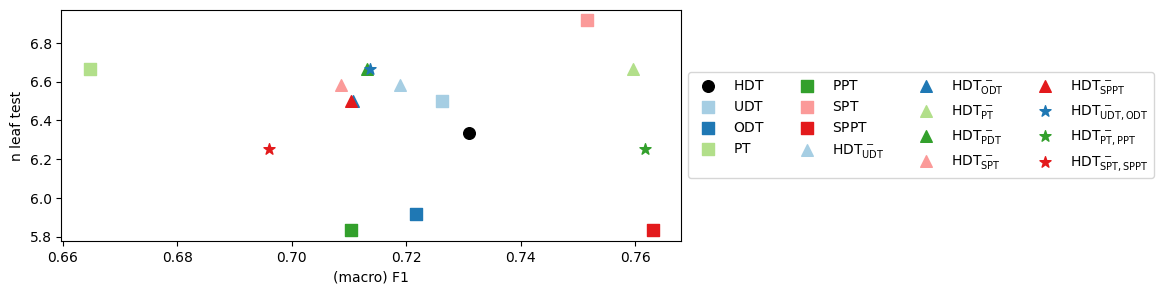

In [95]:
plt.figure(figsize=(8, 3))

y_measure = ['resulting_max_depth_test', 'n_nodes_test', 'n_leaf_test'][2]

df_best = df.sort_values(by=["dataset", "method", 'f1_macro_val', y_measure], ascending=[False]*3+[True])\
            .groupby(["dataset", "method"]).head(1).copy(deep=True)

df_best.resulting_max_depth_test -= 1

df_best = df_best.groupby(by=['method'])[['f1_macro_test', y_measure]].mean().reset_index()

for i, method in enumerate(viz_dict.keys()):
    row = df_best[df_best['method'] == method]
    if not row.empty:
        f1_macro = row['f1_macro_test'].values[0]
        n_nodes = row[y_measure].values[0]
        label, marker, color = viz_dict[method]
        plt.scatter([f1_macro], 
                    [n_nodes], 
                    marker=(2, 0, 45) if marker == '_' else marker, 
                    label=label, 
                    c=color,
                    s=70
        )
        """plt.annotate(
            label, 
            xy=(f1_macro, n_nodes), 
            xytext=(5, 5), 
            textcoords='offset points',
            #arrowprops=dict(arrowstyle='->', lw=0.5),
            fontsize=14
        )"""

plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    ncol=4
)
plt.xlabel('(macro) F1')
plt.ylabel(" ".join(y_measure.split('_')))

plt.show()

In [23]:
[x for x in df.columns if 'test' in x]

['accuracy_test',
 'balanced_accuracy_test',
 'f1_score_test',
 'f1_micro_test',
 'f1_macro_test',
 'f1_weighted_test',
 'precision_score_test',
 'precision_micro_test',
 'precision_macro_test',
 'precision_weighted_test',
 'recall_score_test',
 'recall_micro_test',
 'recall_macro_test',
 'recall_weighted_test',
 'n_leaf_test',
 'n_nodes_test',
 'resulting_max_depth_test']

DROP:
-obliquePivotTree
-MultipleObliquePivotTree

Campioni finali:
- HDT
- HDT no Pivot

Exp finali:
- HDT_no_partial_pivot (HDT-)
- Tutti omogenei

PartialPivot con più scaler

In [24]:
methods = [x for x in df_best_pivot.columns if 'HDT' in x]

methods

['HDT',
 'HDT_no_DecisionTreeStumpClassifier',
 'HDT_no_MultiplePivotTreeStumpClassifier',
 'HDT_no_ObliqueDecisionTreeStumpClassifier',
 'HDT_no_PartialPivotTreeStumpClassifier',
 'HDT_no_PartialProximityTreeStumpClassifier',
 'HDT_no_PivotTreeStumpClassifier',
 'HDT_no_classic',
 'HDT_no_partial',
 'HDT_no_pivot']

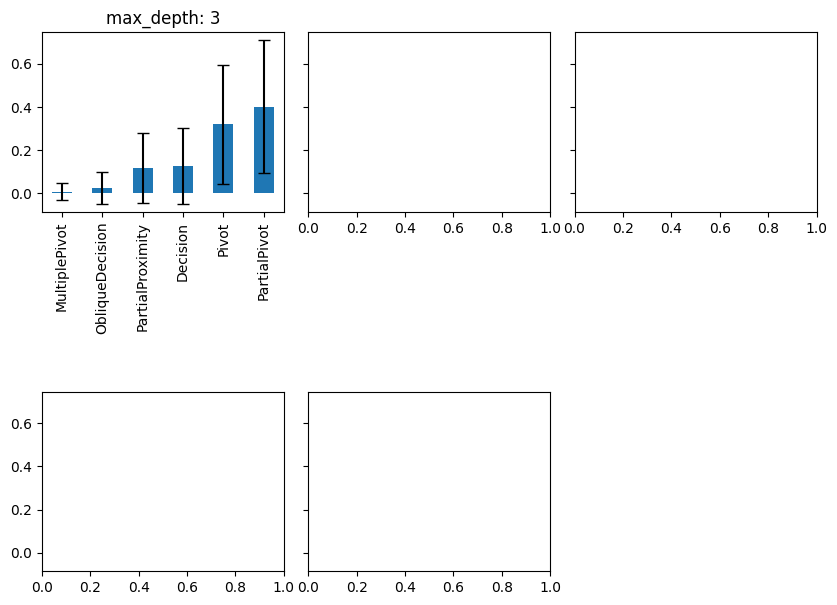

In [25]:
fig, axs = plt.subplots(2,3, figsize=(10, 7), 
                        #sharex=True, 
                        sharey=True
                       )

axs = axs.flatten()
fig.subplots_adjust(wspace=.1, hspace=1)

for ax, max_depth in zip(axs, sorted(df.max_depth.unique())):
    df_best = df[(df.max_depth==max_depth) & (df.method.isin(methods))].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
                .groupby(["dataset", "method"]).head(1)
    df_count = df_best[list(df_count.columns)]
    media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
    std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]
    
    media.plot.bar(yerr=std, capsize=4, ax=ax)
    ax.set_title(f'max_depth: {max_depth}')

#Aggiungere barra che dice profondità media. tutto orizzontale

axs[-1].axis('off')
plt.show()

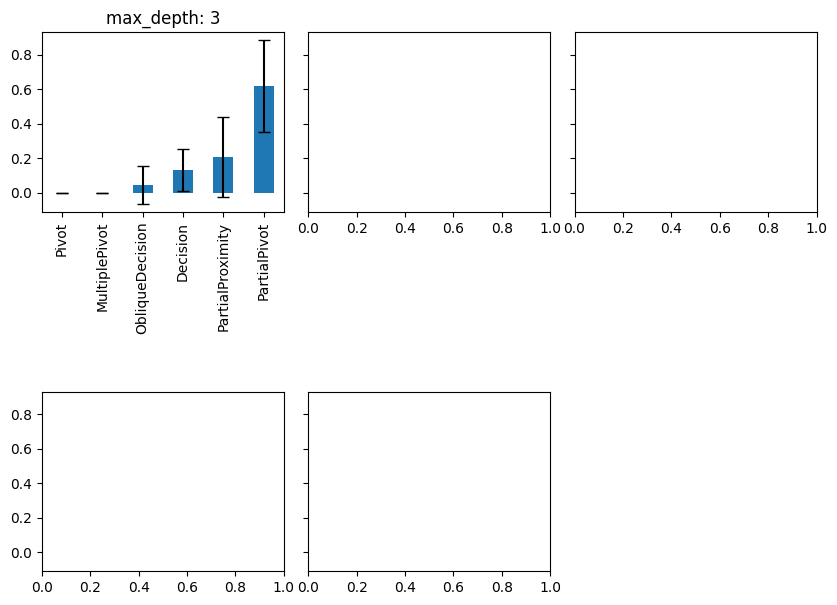

In [26]:
fig, axs = plt.subplots(2,3, figsize=(10, 7), 
                        #sharex=True, 
                        sharey=True
                       )

axs = axs.flatten()
fig.subplots_adjust(wspace=.1, hspace=1)

for ax, max_depth in zip(axs, sorted(df.max_depth.unique())):
    df_best = df[(df.max_depth==max_depth) & (df.method == 'HDT_no_pivot')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
                .groupby(["dataset", "method"]).head(1)
    df_count = df_best[list(df_count.columns)]
    media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
    std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]
    
    media.plot.bar(yerr=std, capsize=4, ax=ax)
    ax.set_title(f'max_depth: {max_depth}')

axs[-1].axis('off')
plt.show()

In [ ]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - count')

Text(0.5, 1.0, 'Overall - weighted on node depth')

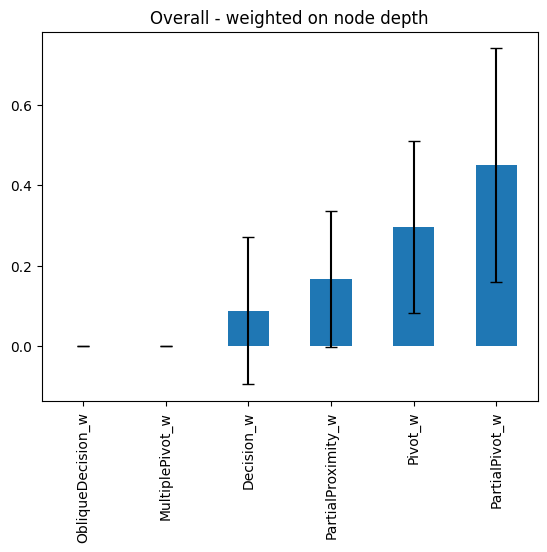

In [33]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count_w.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - weighted on node depth')

Text(0.5, 1.0, 'Overall - weighted on information gain')

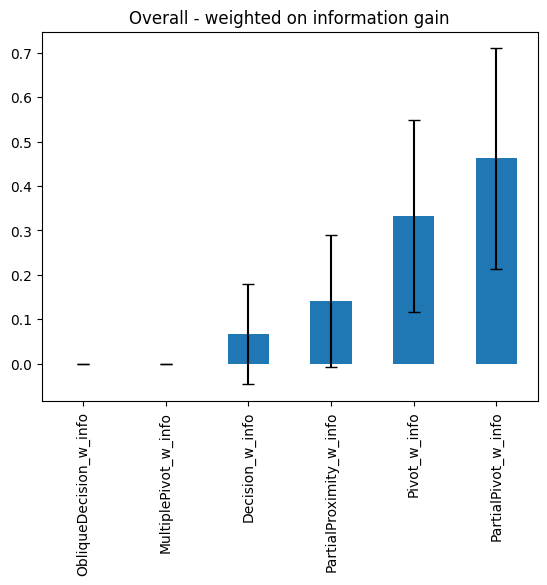

In [34]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count_w_info.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - weighted on information gain')

Text(0.5, 1.0, 'Overall - weighted on impurity decrease')

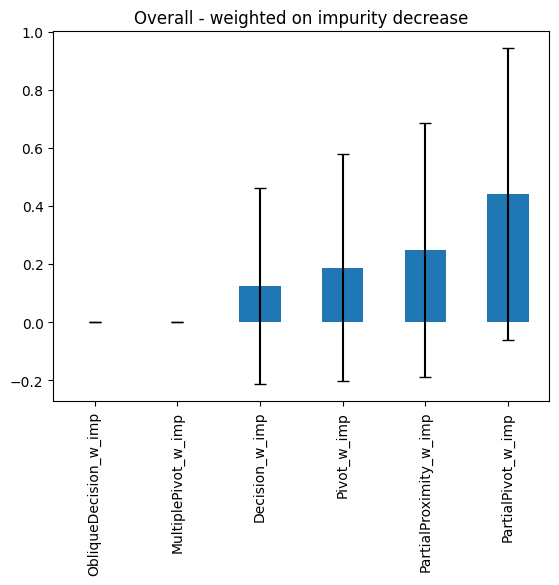

In [35]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count_w_imp.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - weighted on impurity decrease')

In [30]:
for tree in trees:
    display(tree.root)
    break

In [31]:
tree.root.stump.tree_.impurity

array([0.72903208, 0.06876028, 0.74472425])